In [4]:
from utils import *
from tqdm import tqdm
import os

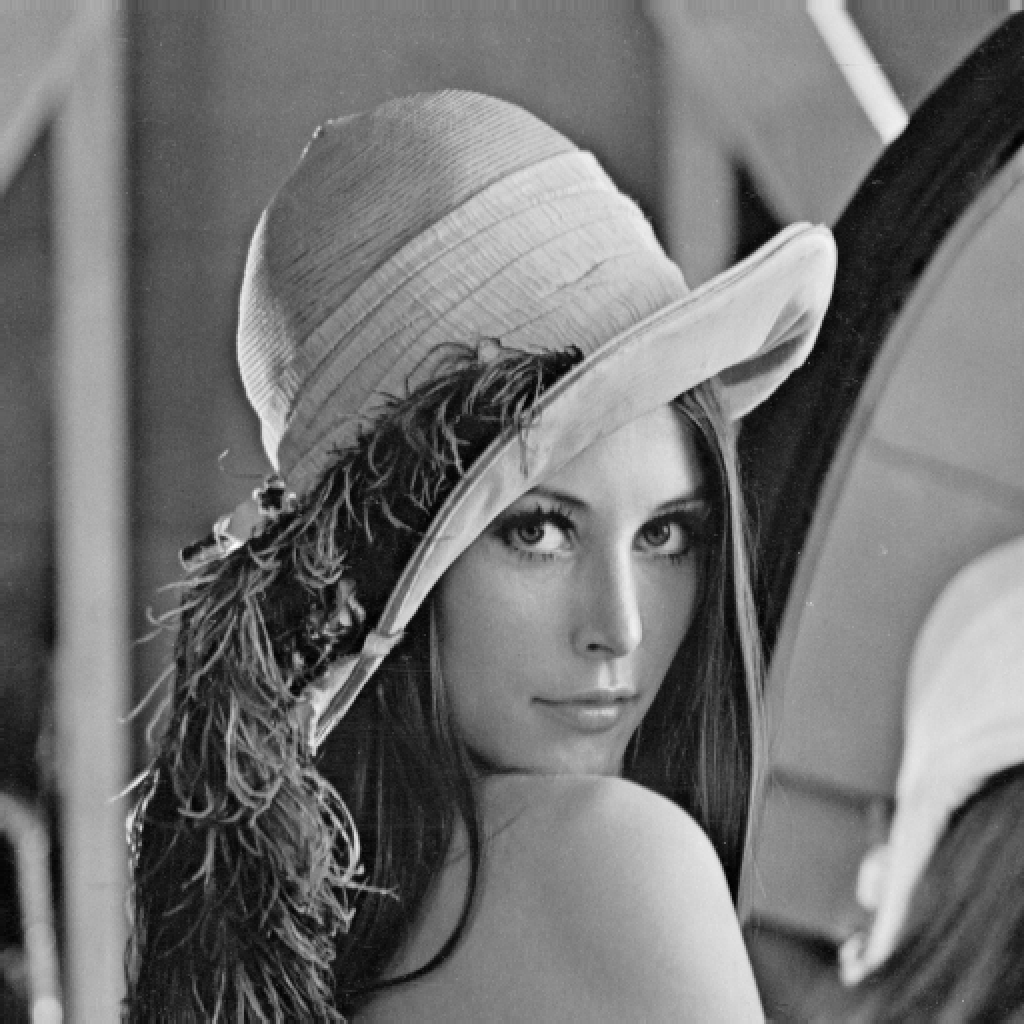

In [18]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/lena_color.png')))
M,N = u0.shape

viewimage(u0)

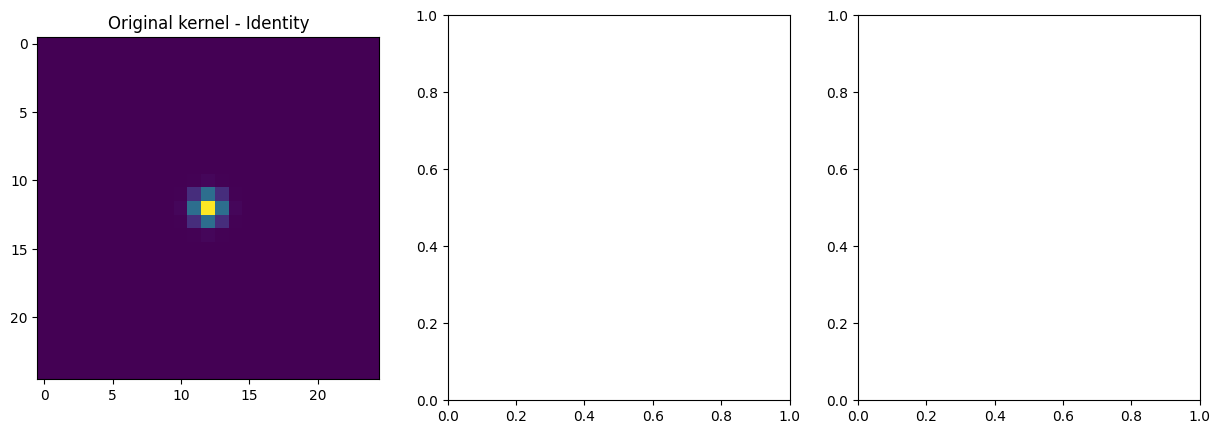

In [26]:
"""m, n = 25, 25
kt = torch.zeros((m,n))
kt[12,12] = 1"""
kt = torch.tensor(np.loadtxt('kernels/kernel0.txt'))
(m,n) = kt.shape

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(kt)
ax[0].set_title('Original kernel - Identity')
# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)) # periodic translation

In [35]:
sigma = 15/255
z = u0 + sigma*torch.randn((M, N))
_, chain_iterates = unadjusted_langevin_dynamics_TVSmoothed(z, sigma, k, niter=1000, tau=1e-3)
xhat = MMSE(chain_iterates)
variances = posterior_variance(chain_iterates)

100%|██████████| 1000/1000 [00:03<00:00, 252.18it/s]


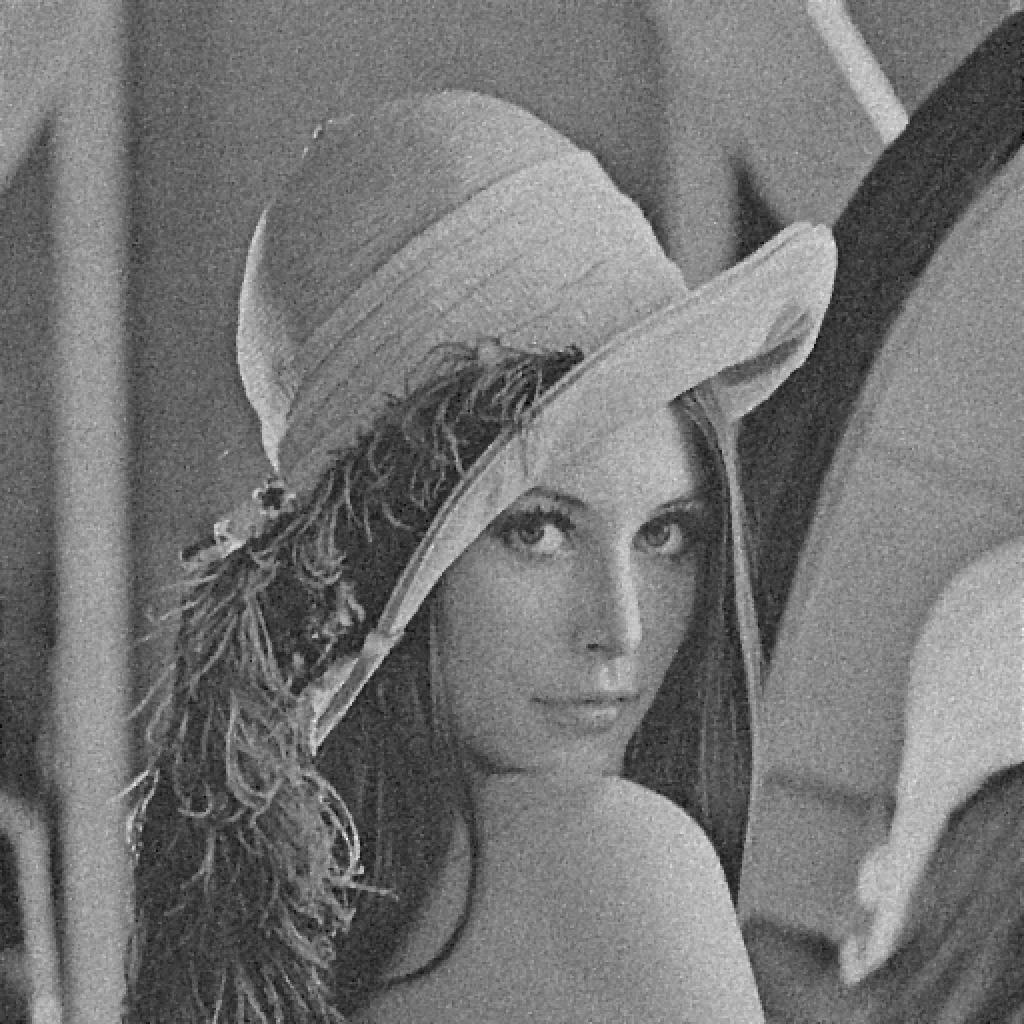

26.363629891894476


In [36]:
viewimage(xhat)
print(psnr(u0, xhat))

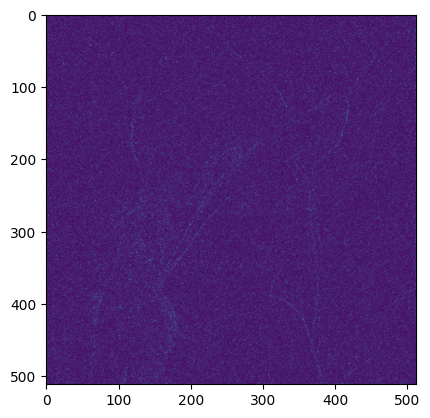

(array([5.57860e+04, 1.41207e+05, 4.79690e+04, 1.21070e+04, 3.38200e+03,
        1.04300e+03, 4.13000e+02, 1.16000e+02, 6.30000e+01, 3.30000e+01,
        1.20000e+01, 3.00000e+00, 6.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.00106555, 0.00402023, 0.00697491, 0.00992958, 0.01288426,
        0.01583894, 0.01879361, 0.02174829, 0.02470297, 0.02765765,
        0.03061232, 0.033567  , 0.03652168, 0.03947635, 0.04243103,
        0.04538571, 0.04834039, 0.05129506, 0.05424974, 0.05720442,
        0.06015909]),
 <BarContainer object of 20 artists>)

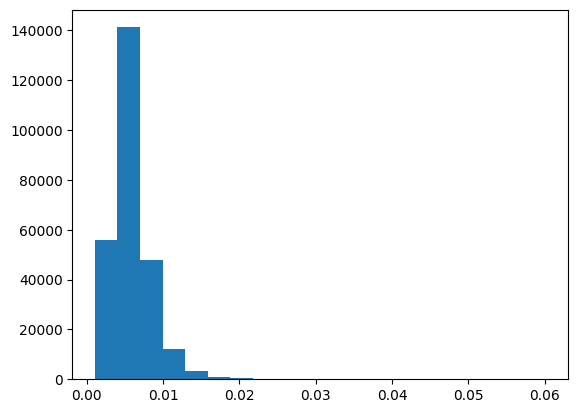

In [37]:
plt.imshow(variances)
plt.show()
plt.hist(variances.flatten(), bins=20)

# Training with ULA

In [38]:
s = []
that = []
sigma = 15/255
lamb = 0.05

limit = 20
count_images = 0

for f in tqdm(os.listdir("data/train")):
    if not f.endswith(".png"):
        continue
    u0 = torch.tensor(rgb2gray(plt.imread(os.path.join("data/train", f))))
    M, N = u0.size()

    # Embed the kernel in a MxN image, and put center at pixel (0,0)
    k = torch.zeros((M,N))
    k[0:m,0:n] = kt/torch.sum(kt)
    k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)) # periodic translation
    z = forward_operator(u0, k) + sigma*torch.randn((M, N))
    x0 = torch.randn((M, N))
    p0 = torch.randn((M, N, 2))
    _, chain_iterates = unadjusted_langevin_dynamics_TVSmoothed(z, sigma, k, niter=2000, tau=1e-3)
    xhat = MMSE(chain_iterates)
    variances = posterior_variance(chain_iterates)
    err = (xhat-u0)**2
    s.extend(err.flatten().tolist())
    that.extend(variances.flatten().tolist())
    count_images += 1
    if count_images >= limit:
        break

 10%|▉         | 20/201 [03:30<31:46, 10.53s/it]


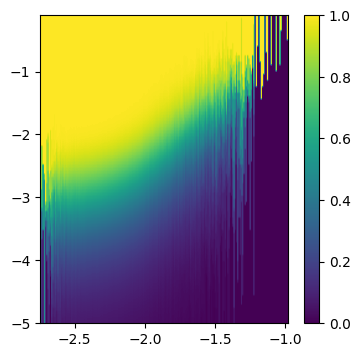

In [39]:
hist, that_edges, s_edges = np.histogram2d(np.log10(that), np.log10(np.array(s)+1e-10), bins=200)
cumhist = np.cumsum(hist, axis=1)
cumhist /= np.where(cumhist[:, -1, None] == 0.0, 1.0, cumhist[:, -1, None])
plt.figure(figsize=(4, 4))
plt.imshow(cumhist.T, origin="lower", extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
plt.colorbar()
plt.xlim(that_edges[0], that_edges[-1])
plt.ylim(-5.0, s_edges[-1])
plt.show()

In [40]:
nbins = 100
var_min = np.min(that)
var_max = np.max(that)
bin_step = (var_max-var_min)/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(len(that)):
    bin = min(nbins-1, int((that[i]-var_min)/bin_step))
    errors_per_bin[bin].append(s[i])
for bin in range(nbins):
    errors_per_bin[bin].sort()
print(list(map(len, errors_per_bin)))

[6685, 161874, 564037, 742209, 608185, 397095, 237675, 139481, 81856, 49375, 31080, 20093, 13272, 9315, 6559, 4577, 3359, 2454, 1846, 1441, 1080, 799, 701, 507, 423, 317, 305, 253, 165, 160, 133, 99, 86, 78, 65, 51, 50, 38, 29, 31, 24, 23, 16, 15, 14, 10, 14, 7, 5, 8, 4, 4, 7, 2, 6, 4, 6, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [47]:
import math

def test_image(path):
    u0 = torch.tensor(rgb2gray(plt.imread(path)))
    M, N = u0.size()
    # Embed the kernel in a MxN image, and put center at pixel (0,0)
    k = torch.zeros((M,N))
    k[0:m,0:n] = kt/torch.sum(kt)
    k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)) # periodic translation
    z = forward_operator(u0, k) + sigma*torch.randn((M, N))
    _, chain_iterates = unadjusted_langevin_dynamics_TVSmoothed(z, sigma, k, niter=2000, tau=1e-3)
    xhat = MMSE(chain_iterates)
    variances = posterior_variance(chain_iterates)
    estimated_errors = torch.zeros_like(xhat)
    for i in range(M):
        for j in range(N):
            bin = max(0, min(nbins-1, int((variances[i, j]-var_min)/bin_step)))
            quantile = math.ceil(.9*len(errors_per_bin[bin]))-1
            quantile = max(0, quantile)
            estimated_errors[i, j] = errors_per_bin[bin][quantile]
    errors = (xhat - u0)**2
    
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 5, 1)
    plt.imshow(u0, cmap="gray")
    plt.title("Ground truth")
    plt.subplot(1, 5, 2)
    plt.imshow(z, cmap="gray")
    plt.title("Corrupted image")
    plt.subplot(1, 5, 3)
    plt.imshow(xhat, cmap="gray")
    plt.title("MMSE estimator")
    plt.subplot(1, 5, 4)
    plt.imshow(errors, vmin=0, vmax=0.02)
    plt.title("Error")
    plt.subplot(1, 5, 5)
    plt.imshow(estimated_errors, vmin=0, vmax=0.02)
    plt.title("Estimated error")
    plt.show()

    viewimage(u0)
    viewimage(z)

    coverage = torch.sum(errors <= estimated_errors)/torch.numel(errors)
    print(f"Coverage: {coverage}")

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:10<00:00, 199.69it/s]


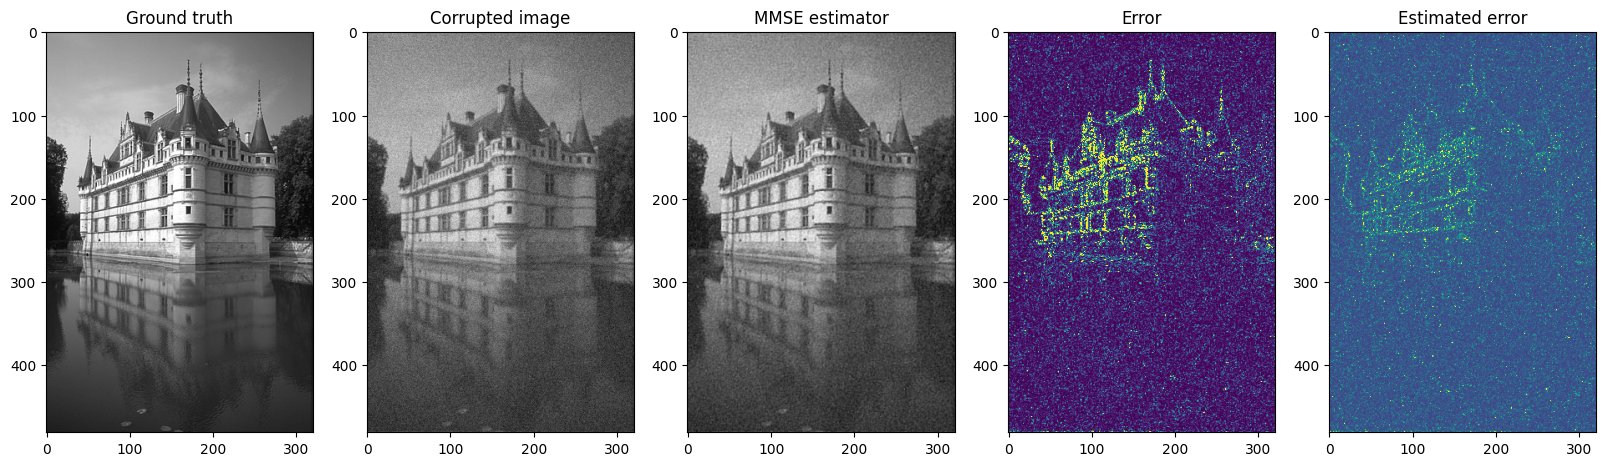

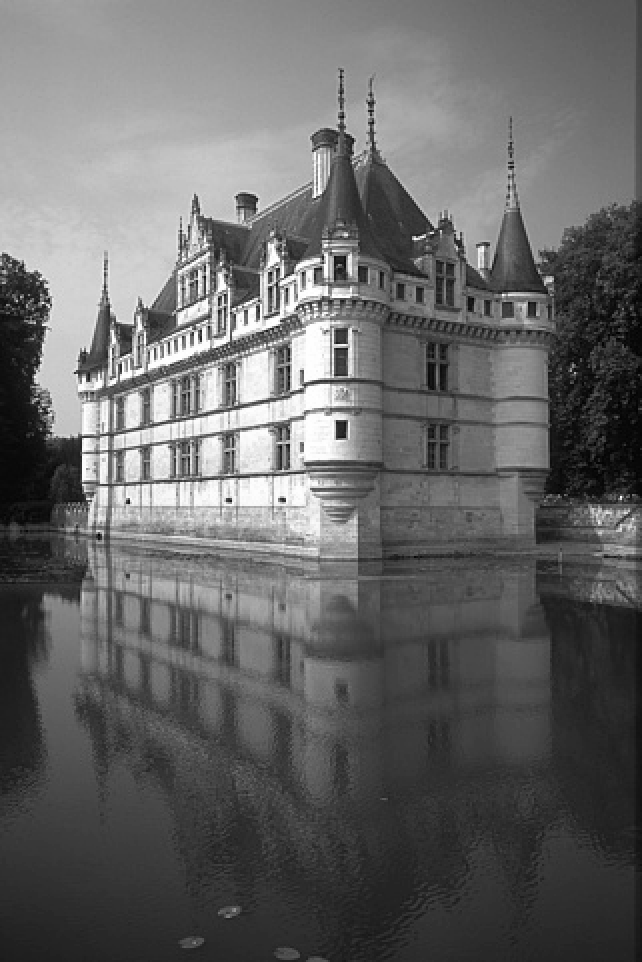

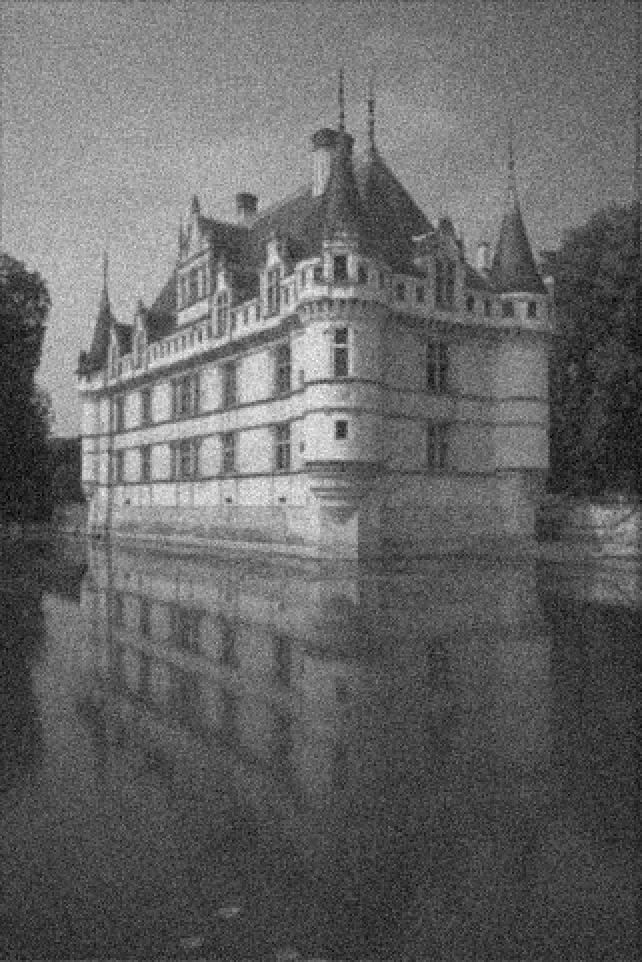

Coverage: 0.8747547268867493


In [48]:
test_image("data/test/102061.png")